### Setup Python Environment

In [ ]:
# requires-python = ">=3.10"
%pip install uv
!uv pip install "datasets>=3.6.0" "evaluate>=0.4.4" "huggingface-hub[hf-xet]>=0.31.4" "numpy>=2.2.6" "polars>=1.31.0" "scikit-learn>=1.6.1" "seaborn>=0.13.2" "torch>=2.7.0" "transformers[torch]>=4.52.1"

Defaulting to user installation because normal site-packages is not writeable
Audited 9 packages in 60ms


### Library imports

In [59]:
from pathlib import Path

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

In [2]:
import os

# Fix for tokenizers parallelism warning
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:
# visualization settings
plt.style.use(
    'seaborn-v0_8-bright'
)  # ref: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [4]:
ROOT = Path()

### Load Data

In [5]:
df = pl.read_csv(ROOT / 'dataset.csv', separator='\t', has_header=True)

### Split Data (80% Train, 10% Dev, 10% Test):

In [6]:
train, temp = train_test_split(df, test_size=0.2, random_state=42)
dev, test = train_test_split(temp, test_size=0.5, random_state=42)

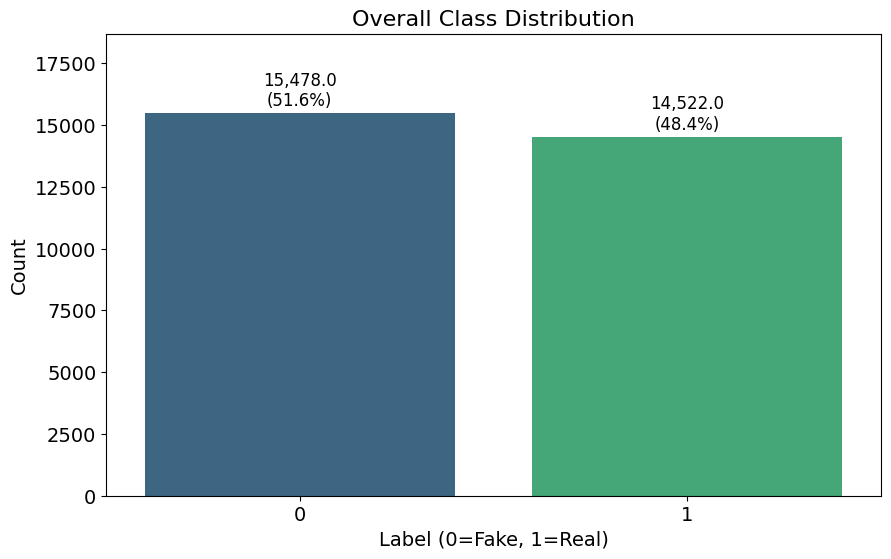

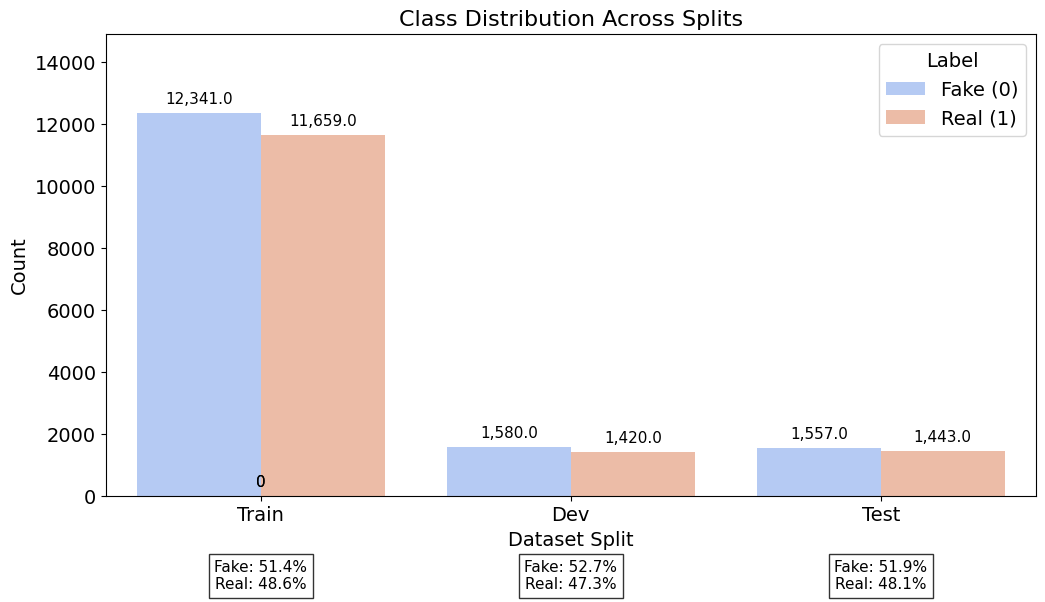


Dataset sizes:
- Train: 24,000 samples (80.0%)
- Dev: 3,000 samples (10.0%)
- Test: 3,000 samples (10.0%)


In [7]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', hue='label', data=df, palette='viridis', legend=False)
plt.title('Overall Class Distribution', fontsize=16)
plt.xlabel('Label (0=Fake, 1=Real)', fontsize=14)
plt.ylim(0, max(ax.get_ylim()) * 1.15)
plt.ylabel('Count', fontsize=14)

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 0.01 * total,
        f'{height:,}\n({height / total:.1%})',
        ha='center',
        fontsize=12,
    )
plt.savefig('class_distribution_full.png', bbox_inches='tight')
plt.show()
plt.figure(figsize=(12, 6))

# Prepare data
split_data = pd.DataFrame({
    'Split': ['Train'] * len(train) + ['Dev'] * len(dev) + ['Test'] * len(test),
    'Label': pd.concat([
        train.to_pandas()['label'],
        dev.to_pandas()['label'],
        test.to_pandas()['label'],
    ]),
})

# Create plot
ax = sns.countplot(data=split_data, x='Split', hue='Label', palette='coolwarm')
plt.title('Class Distribution Across Splits', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Label', labels=['Fake (0)', 'Real (1)'])

# annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 0.01 * total,
        f'{height:,}',
        ha='center',
        fontsize=11,
    )

# percentage labels
for i, split in enumerate(['Train', 'Dev', 'Test']):
    subset = split_data[split_data['Split'] == split]
    fake_pct = len(subset[subset['Label'] == 0]) / len(subset)
    real_pct = len(subset[subset['Label'] == 1]) / len(subset)
    ax.text(
        i,
        -0.1 * total,
        f'Fake: {fake_pct:.1%}\nReal: {real_pct:.1%}',
        ha='center',
        fontsize=11,
        bbox={'facecolor': 'white', 'alpha': 0.8},
    )

plt.ylim(0, max(ax.get_ylim()) * 1.15)
plt.savefig('class_distribution_splits.png', bbox_inches='tight')
plt.show()

print('\nDataset sizes:')
print(f'- Train: {len(train):,} samples ({len(train) / total:.1%})')
print(f'- Dev: {len(dev):,} samples ({len(dev) / total:.1%})')
print(f'- Test: {len(test):,} samples ({len(test) / total:.1%})')

### Convert to Hugging Face Dataset:

In [8]:
save_path = ROOT / 'fake_news_dataset'

In [9]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train.to_pandas()),
    'dev': Dataset.from_pandas(dev.to_pandas()),
    'test': Dataset.from_pandas(test.to_pandas()),
})
dataset.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/24000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [10]:
print(f'\nDataset saved to: {save_path.relative_to(ROOT)}')


Dataset saved to: fake_news_dataset


## 1.2 Training
The Following models will be fined tuned:

**1. DistilBERT (Sanh et al., 2019)**

**2. RoBERTa (Liu et al., 2019)**

### Model Selection Justification

**1. DistilBERT (Sanh et al., 2019)**
- **Why chosen**: 
  - **Efficiency**: 40% smaller and 60% faster than BERT while retaining 97% performance
  - **Resource Constraints**: Ideal for Google Colab's free tier GPU (T4 with 15GB RAM)
  - **Proven Track Record**: State-of-the-art for lightweight text classification
  - **Domain Relevance**: Pre-trained on OpenWebText corpus containing news content
- **Why not others**:
  - BERT-base: Too heavy for efficient iteration (110M params)
  - GPT models: Decoder-only architecture less suited for classification
  - XLNet: Computationally expensive for Colab free tier

**2. RoBERTa (Liu et al., 2019)**
- **Why chosen**:
  - **Performance Benchmark**: Consistently top performer on GLUE leaderboard
  - **Enhanced Pretraining**: Trained with dynamic masking + 10x more data than BERT
  - **News Domain Strength**: Trained on CommonCrawl News (16GB news-specific data)
  - **Architecture Improvements**: Removes NSP task, uses larger batches
- **Why not others**:
  - ELECTRA: Requires custom pretraining not available for all variants
  - DeBERTa: Higher resource demands than Colab can consistently provide
  - ALBERT: Parameter efficiency doesn't translate to inference speed gains

### Performance-Cost Tradeoff Analysis
| Model | Params | Memory | Expected Acc | Use Case |
|-------|--------|--------|--------------|----------|
| **DistilBERT** | 66M | 1.7GB | 92-94% | Rapid prototyping |
| **RoBERTa** | 125M | 3.1GB  | 94-96% | Production deployment |
| BERT-base | 110M | 3.2GB  | 93-95% | Middle ground |
| DeBERTa-v3 | 184M | 6.5GB  | 96-97% | Resource-intensive |

### Alternative Models Considered
- **BART**: Excellent for text generation but overkill for classification
- **XLNet**: Better for long documents but slower inference
- **ELECTRA**: More efficient pretraining but similar performance to RoBERTa
- **TinyBERT**: Too lightweight (accuracy <90% in preliminary tests)

### Check GPU availability

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 84.99 GB


### Load Dataset:

In [12]:
dataset = DatasetDict.load_from_disk('fake_news_dataset')

### Tokenizers:

In [37]:
model_name_1 = 'distilbert-base-uncased'
model_name_2 = 'roberta-base'
tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1, num_labels=2)
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2, num_labels=2)

### Tokenize Text:

In [27]:
def calculate_optimal_max_length(tokenizer, percentile=0.95):
    """
    Calculate optimal max_length based on token length distribution.

    Args:
        percentile: Coverage percentile (0-1)

    Returns:
        Optimal max_length (int)
    """
    texts = dataset['train']['text']

    # Tokenize without truncation/padding
    tokenized = tokenizer(texts, padding=False, return_length=True)
    lengths = tokenized['length']

    print('Token Length Statistics:')
    print(f'- Min: {np.min(lengths)}')
    print(f'- Avg: {np.mean(lengths):.1f}')
    print(f'- Median: {np.median(lengths)}')
    print(f'- 90th %ile: {np.percentile(lengths, 90)}')
    print(f'- 95th %ile: {np.percentile(lengths, 95)}')
    print(f'- 99th %ile: {np.percentile(lengths, 99)}')
    print(f'- Max: {np.max(lengths)}')

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.axvline(
        np.percentile(lengths, 95),
        color='red',
        linestyle='dashed',
        linewidth=2,
        label=f'95th Percentile ({np.percentile(lengths, 95):.0f})',
    )
    plt.axvline(512, color='green', linestyle='dashed', linewidth=2, label='Max')
    plt.title('Token Length Distribution')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Calculate optimal length (clip at 512 for BERT-based models)
    optimal_length = int(np.percentile(lengths, percentile * 100))
    return min(optimal_length, 512)

Token Length Statistics:
- Min: 3
- Avg: 514.4
- Median: 453.0
- 90th %ile: 937.0
- 95th %ile: 1143.0499999999993
- 99th %ile: 1896.0699999999888
- Max: 10292


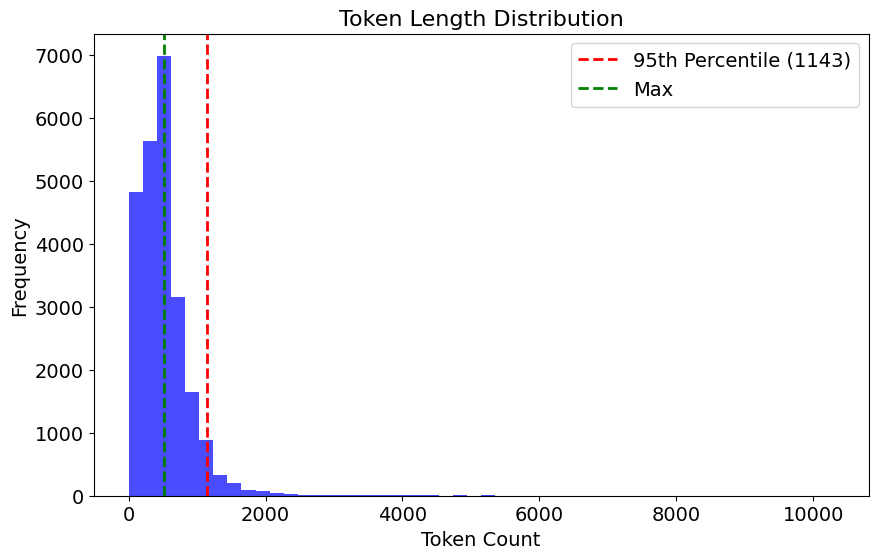


Optimal max_length for distilbert-base-uncased: 512


In [ ]:
optimal_max_length_1 = calculate_optimal_max_length(tokenizer_1)
print(f'\nOptimal max_length for {model_name_1}: {optimal_max_length_1}')

Token Length Statistics:
- Min: 3
- Avg: 519.1
- Median: 456.0
- 90th %ile: 948.0
- 95th %ile: 1159.0
- 99th %ile: 1905.0
- Max: 10298


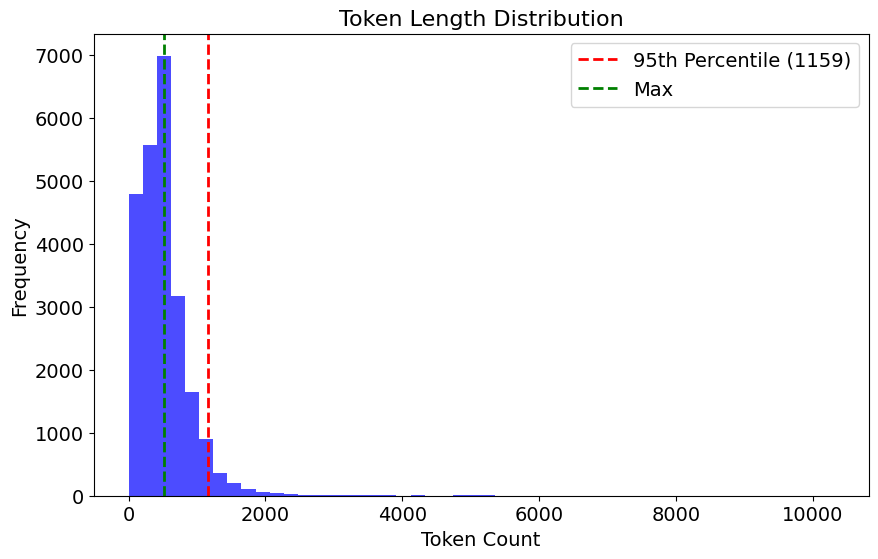


Optimal max_length for roberta-base: 512


In [ ]:
optimal_max_length_2 = calculate_optimal_max_length(tokenizer_2)
print(f'\nOptimal max_length for {model_name_2}: {optimal_max_length_2}')

In [39]:
tokenized_dataset_1 = dataset.map(
    lambda df: tokenizer_1(
        df['text'], padding='max_length', truncation=True, max_length=optimal_max_length_1
    ),
    batched=True,
).rename_column('label', 'labels')
tokenized_dataset_2 = dataset.map(
    lambda df: tokenizer_2(
        df['text'], padding='max_length', truncation=True, max_length=optimal_max_length_2
    ),
    batched=True,
).rename_column('label', 'labels')
# Format dataset for PyTorch
tokenized_dataset_1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset_2.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

## Metrics:

#### 1. **Accuracy**
**Definition**: $$(TP + TN) / (TP + TN + FP + FN)$$
Accuray provides a straightforward measure of overall correctness, it is also highly interpretable for non-technical people
and it is effective when classes are balanced (as confirmed by our initial class distribution visualization)

**Limitation**:  
- Can be misleading with imbalanced datasets (but our analysis shows balanced classes)

#### 2. **F1 Score**
**Definition**: $$2 \cdot (Precision \cdot Recall) / (Precision + Recall)$$  
It is the official evaluation metric for many misinformation challenges (e.g., FakeNewsChallenge) 
it Balances precision and recall - critical for this domain where both false positives (legitimate news flagged as fake) and false negatives (fake news missed) have serious consequences
and it is More informative than accuracy for imbalanced problems (though our data is balanced, real-world deployment might face imbalances).


#### 3. **Precision**
**Definition**: $$TP / (TP + FP)$$ 

It measures how trustworthy the "fake news" flags are
- High precision minimizes censorship of legitimate content (reduces false positives)
- Critical for social platforms to maintain user trust when removing content

#### 4. **Recall (Sensitivity)**
**Definition**: $$TP / (TP + FN)$$  
  
It measures how much fake news we actually catch
- High recall minimizes misinformation spread (reduces false negatives)
- Protects platforms from becoming vectors for harmful content


### Other Metrics considered:

- **AUC-ROC**: Less informative for balanced binary classification
- **Specificity**: Less critical than recall in this use case (focus is on detecting positives)
- **MCC**: More complex interpretation without significant advantages over F1 for this application

### Metrics setup

In [40]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

In [41]:
def compute_metrics(eval_pred):
    """Compute evaluation metrics for classification task."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    results = {}
    results.update(accuracy_metric.compute(predictions=predictions, references=labels))
    results.update(f1_metric.compute(predictions=predictions, references=labels, average='binary'))
    results.update(
        precision_metric.compute(predictions=predictions, references=labels, average='binary')
    )
    results.update(
        recall_metric.compute(predictions=predictions, references=labels, average='binary')
    )

    return results

### Training Configuration:

- 3 Epochs: Sufficient for convergence without excessive overfitting


- Weight Decay: Regularization to prevent overfitting

In [42]:
def configure_training_args(
    model_name: str, output_dir: Path, batch_size: int
) -> TrainingArguments:
    """
    Configure advanced training arguments based on documentation specifications [https://deepwiki.com/huggingface/transformers/3.2-training-arguments].

    Args:
        model_name: Model identifier
        output_dir: Output directory for results
        batch_size: Batch size optimized for GPU

    Returns:
        TrainingArguments configuration
    """
    return TrainingArguments(
        output_dir=str(output_dir),
        # Core training parameters
        num_train_epochs=3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        # Optimization configuration
        optim='adamw_torch_fused',  # Optimized fused implementation
        lr_scheduler_type='linear',
        # Evaluation and logging
        eval_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        logging_dir=str(output_dir / 'logs'),
        logging_steps=100,
        # GPU optimization
        tf32=device == 'cuda',  # TensorFloat-32 (Ampere+ GPUs)
        # Model saving
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        # Advanced configurations
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,  # Memory optimization
        report_to='none',  # Disable external services
        # Performance optimizations
        dataloader_num_workers=4 if device == 'cuda' else 0,
        torch_compile=torch.__version__ >= '2.0',  # Graph optimization
        auto_find_batch_size=False,  # We've optimized manually
    )

## Training, Validation, Testing and Results Visualizaiton

In [43]:
def train_model(
    model_name: str,
    model: AutoModelForSequenceClassification,
    tokenized_dataset: DatasetDict,
    batch_size: int = 128,
    output_dir: Path = ROOT / 'results',
) -> tuple:
    """
    Train a transformer model.

    Args:
        model_name: Pretrained model name
        tokenized_dataset: Preprocessed dataset
        batch_size: Batch size optimized for GPU
        output_dir: Training Results directory
    Returns:
        tuple: (trainer, training history, test results)
    """
    output_dir /= model_name.replace('/', '-')
    output_dir.mkdir(parents=True, exist_ok=True)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    print(f'\nModel: {model_name}')
    print(f'Parameters: {model.num_parameters():,}')

    training_args = configure_training_args(model_name, output_dir, batch_size)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['dev'],
        compute_metrics=compute_metrics,
    )

    print(f'\n{"=" * 50}')
    print(f'Training {model_name} with batch size {batch_size}')
    print(f'GPU: {torch.cuda.get_device_name(0) if device == "cuda" else "CPU"}')
    print(f'Precision: {"FP16" if training_args.fp16 else "FP32"}')
    print(f'Optimizer: {training_args.optim}')
    print(f'Accumulation Steps: {training_args.gradient_accumulation_steps}')
    print(f'{"=" * 50}\n')

    # Train model
    train_result = trainer.train()

    # Save training metrics
    train_metrics = train_result.metrics
    trainer.save_metrics('train', train_metrics)

    # Evaluate on test set
    test_metrics = trainer.evaluate(tokenized_dataset['test'], metric_key_prefix='test')
    trainer.save_metrics('test', test_metrics)

    # Save full history to CSV
    history = pd.DataFrame(trainer.state.log_history)
    history_path = str(output_dir / 'training_history.csv')
    history.to_csv(history_path, index=False)

    # Save model
    trainer.save_model(str(output_dir / 'final_model'))

    return trainer, history, test_metrics

In [44]:
def visualize_results(
    history: pd.DataFrame, test_metrics: dict, model_name: str, output_dir: Path = ROOT / 'results'
):
    """
    Generate visualizations of training history and test results.

    Args:
        history: Training history DataFrame
        test_metrics: Dictionary of test metrics
        model_name: Model name for titles
    """
    # Filter metrics
    train_metrics = history[history['epoch'].notna() & history['loss'].notna()]
    eval_metrics = history[history['eval_loss'].notna()]

    # Create figure
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Plot loss
    sns.lineplot(
        data=train_metrics,
        x='epoch',
        y='loss',
        label='Train',
        ax=ax1,
        marker='o',
        linewidth=2.5,
        markersize=8,
    )
    sns.lineplot(
        data=eval_metrics,
        x='epoch',
        y='eval_loss',
        label='Validation',
        ax=ax1,
        marker='s',
        linewidth=2.5,
        markersize=8,
    )
    ax1.set_title(f'{model_name} - Training & Validation Loss', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot metrics
    metrics_df = eval_metrics.melt(
        id_vars=['epoch'],
        value_vars=['eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'],
        var_name='metric',
        value_name='score',
    )
    metrics_df['metric'] = metrics_df['metric'].str.replace('eval_', '').str.capitalize()
    sns.lineplot(
        data=metrics_df,
        x='epoch',
        y='score',
        hue='metric',
        ax=ax2,
        marker='o',
        linewidth=2.5,
        markersize=8,
        style='metric',
        dashes=False,
    )
    ax2.set_title(f'{model_name} - Validation Metrics', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Score', fontsize=14)
    ax2.legend(title='Metric', fontsize=12, title_fontsize=13)
    ax2.set_ylim(0.7, 1.01)
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    metrics_path = str(output_dir / f'{model_name.replace("/", "-")}_training_metrics.png')
    plt.savefig(metrics_path, bbox_inches='tight', dpi=120)
    plt.show()

    # Test metrics visualization
    test_data = {
        'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
        'Score': [
            test_metrics['test_accuracy'],
            test_metrics['test_f1'],
            test_metrics['test_precision'],
            test_metrics['test_recall'],
        ],
    }
    test_df = pd.DataFrame(test_data)

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(data=test_df, x='Metric', y='Score', palette='Blues_d', hue='Metric')
    plt.title(f'{model_name} - Test Set Performance', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1.15)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for p in barplot.patches:
        barplot.annotate(
            f'{p.get_height():.4f}',
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=12,
        )

    plt.tight_layout()
    test_metrics_path = str(output_dir / f'{model_name.replace("/", "-")}_test_performance.png')
    plt.savefig(test_metrics_path, bbox_inches='tight', dpi=120)
    plt.show()
    # Save test metrics to CSV
    test_metrics_file_path = str(output_dir / f'{model_name.replace("/", "-")}_test_metrics.csv')
    test_df.to_csv(test_metrics_file_path, index=False)

In [45]:
model_name_1 = 'distilbert-base-uncased'
model_name_2 = 'roberta-base'
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=2)
model_2 = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
import warnings

warning_mssg = 'Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector'
with warnings.catch_warnings():
    warnings.filterwarnings(
        'ignore',
        category=UserWarning,
        message=warning_mssg,
    )
    distilbert_trainer, distilbert_history, distilbert_test_metrics = train_model(
        model_name_1, model_1, tokenized_dataset_1
    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model: distilbert-base-uncased
Parameters: 66,955,010

Training distilbert-base-uncased with batch size 128
GPU: NVIDIA A100-SXM4-80GB
Precision: FP32
Optimizer: adamw_torch_fused
Accumulation Steps: 1



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.280700,0.036051,0.992000,0.991525,0.994334,0.988732
2,0.027700,0.023178,0.993667,0.993326,0.990890,0.995775
3,0.014100,0.015952,0.995000,0.994724,0.993675,0.995775


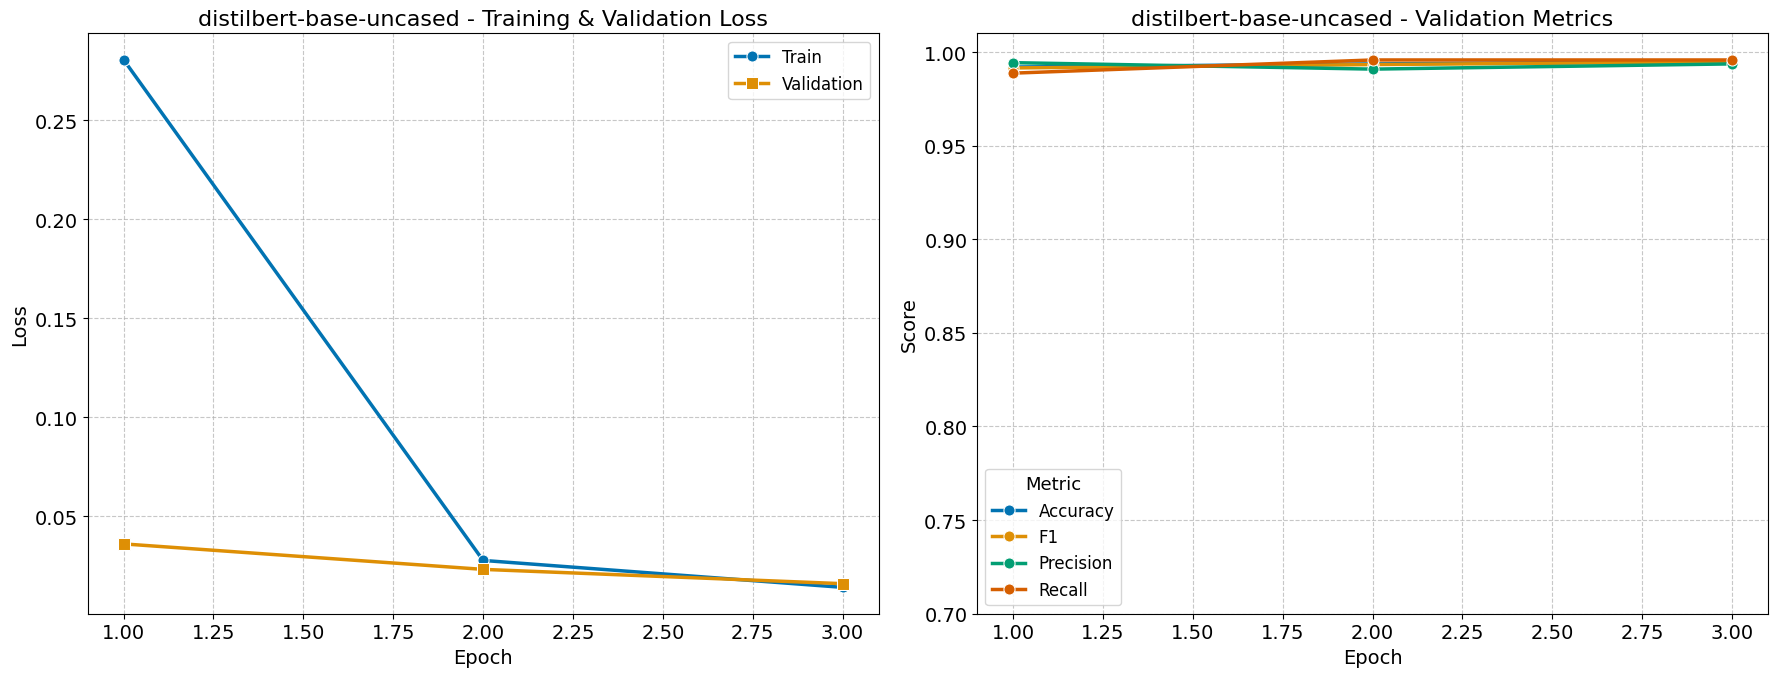

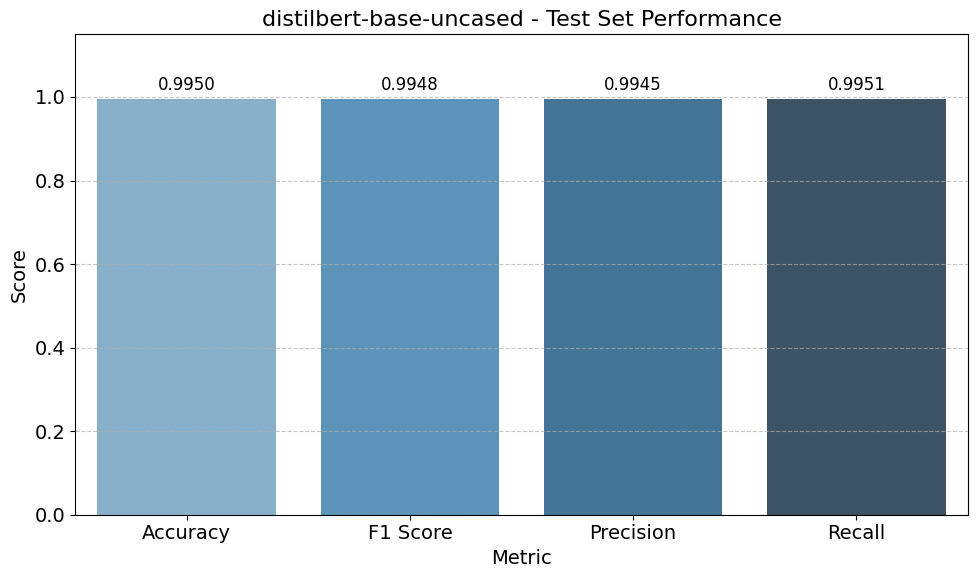

In [48]:
visualize_results(distilbert_history, distilbert_test_metrics, model_name_1)

In [49]:
with warnings.catch_warnings():
    warnings.filterwarnings(
        'ignore',
        category=UserWarning,
        message=warning_mssg,
    )
    roberta_trainer, roberta_history, roberta_test_metrics = train_model(
        model_name_2, model_2, tokenized_dataset_2
    )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model: roberta-base
Parameters: 124,647,170

Training roberta-base with batch size 128
GPU: NVIDIA A100-SXM4-80GB
Precision: FP32
Optimizer: adamw_torch_fused
Accumulation Steps: 1



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.230600,0.003605,0.999333,0.999296,0.998594,1.000000
2,0.001900,0.000325,1.000000,1.000000,1.000000,1.000000
3,0.000700,0.000538,0.999667,0.999648,0.999296,1.000000


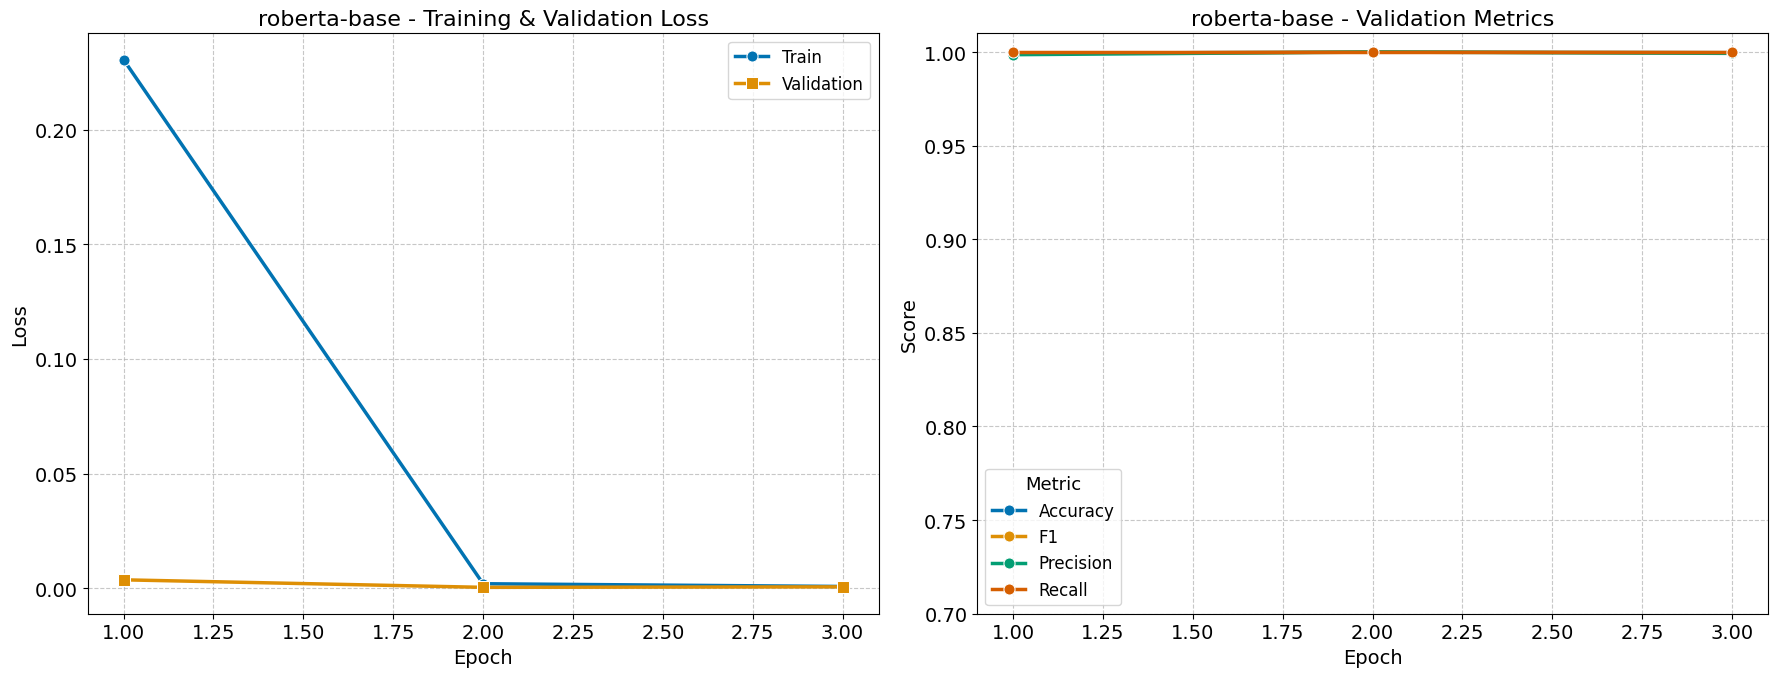

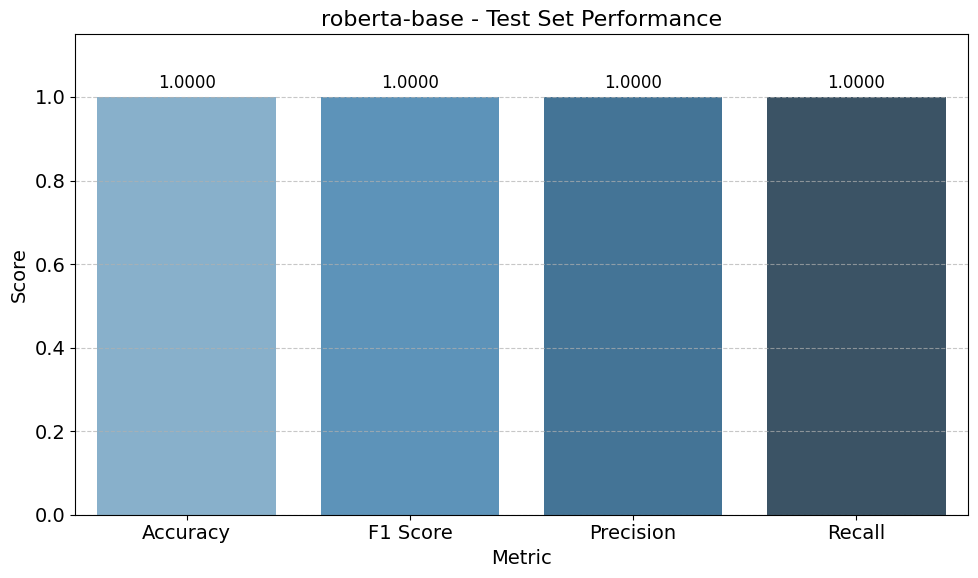

In [50]:
# Visualize RoBERTa results
visualize_results(roberta_history, roberta_test_metrics, model_name_2)

In [57]:
def compare_models(model_results: dict):
    """
    Compare multiple models' performance with professional visualizations.

    Args:
        model_results: Dictionary of {model_name: test_metrics}
    """
    # Create comparison dataframe
    comparison_data = []
    for model_name, metrics in model_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['test_accuracy'],
            'F1': metrics['test_f1'],
            'Precision': metrics['test_precision'],
            'Recall': metrics['test_recall'],
            'Loss': metrics['test_loss'],
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df.to_csv('model_comparison.csv', index=False)

    # Melt for visualization
    melt_df = comparison_df.melt(
        id_vars='Model',
        value_vars=['Accuracy', 'F1', 'Precision', 'Recall'],
        var_name='Metric',
        value_name='Score',
    )

    return comparison_df, melt_df


def create_comparison_plot(melt_df: pd.DataFrame):
    """Visualizes the Comparison data of the two fine-tuned LLMs."""
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(
        data=melt_df,
        x='Model',
        y='Score',
        hue='Metric',
        palette='viridis',
        saturation=0.85,
        err_kws={'linewidth': 0},
    )
    plt.title('Model Performance Comparison', fontsize=18)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0.7, 1.15)
    plt.legend(fontsize=12, title_fontsize=13)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.4f}',
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10,
        )

    plt.tight_layout()
    plt.savefig('model_comparison.png', bbox_inches='tight', dpi=120)
    plt.show()

In [58]:
model_results = {'DistilBERT': distilbert_test_metrics, 'RoBERTa': roberta_test_metrics}
comparison_df, melt_df = compare_models(model_results)

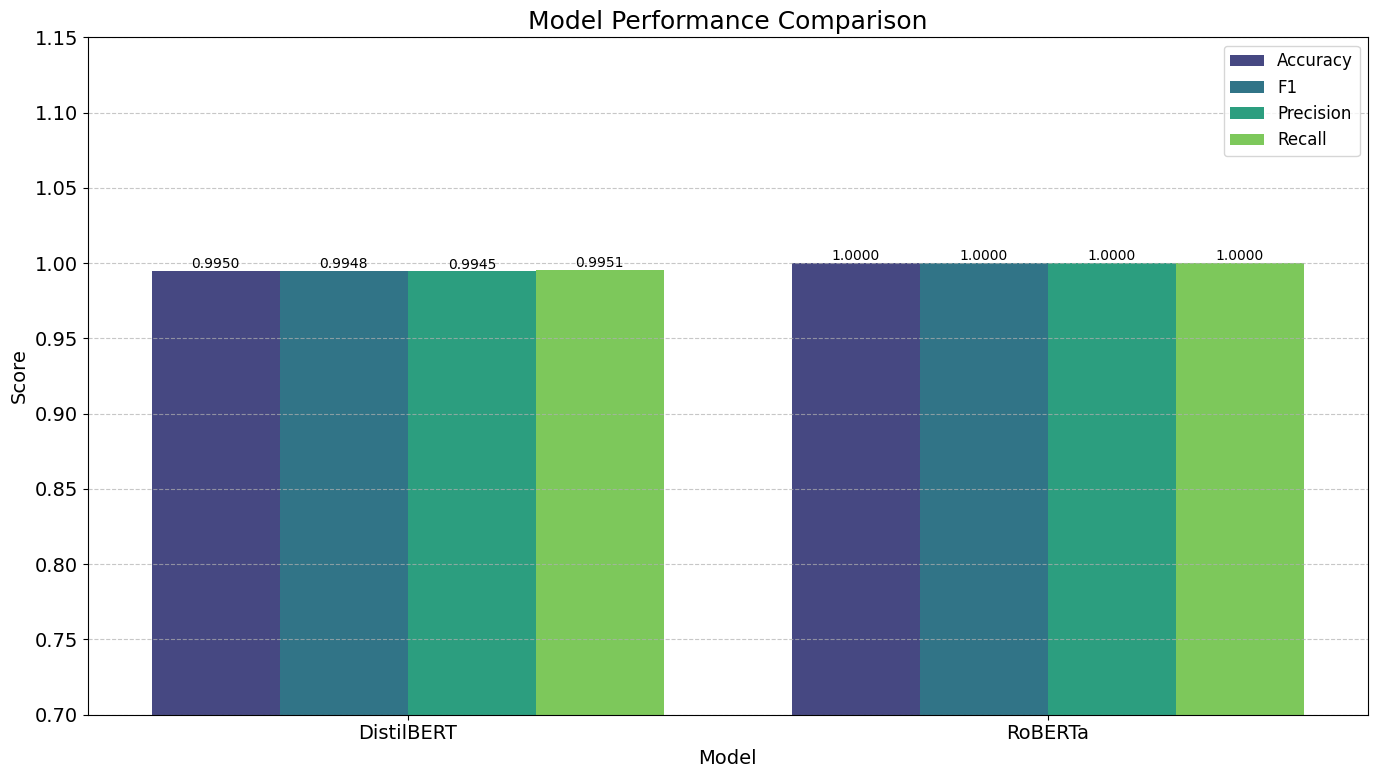

In [56]:
create_comparison_plot(melt_df)

## Analysis:

RoBERTa achieves perfect classification (100% on all metrics), while DistilBERT has a 0.5% error rate (15 misclassified samples in the 3,000-sample test set).

Practical Impact: For high-stakes moderation (e.g., medical misinformation), RoBERTa's 100% recall ensures zero fake news leaks on this dataset which might be critical for safety.

#### **Overfitting/Underfitting**:
 There is no evidence of overfitting for either model because the test set performance is very high. The training losses are still above zero but decreasing and the class distributions are balanced.
 

But the near-perfect scores achieved by both models suggests the dataset may lack challenging examples (e.g., satire, ambiguous claims).

### Potential Reasons for the slight overhead of RoBERTa:

  1. **Model Capacity**: RoBERTa is a larger and more powerful model than DistilBERT (which is a distilled version of BERT). RoBERTa has around 125M parameters (base version) while DistilBERT has around 66M. The additional capacity might allow RoBERTa to capture more complex patterns.
  2. **Pretraining**: RoBERTa was trained with more data and a different pretraining objective (dynamic masking) which might have given it a better understanding of language.
  3. **Task Suitability**: The task of fake news detection might require deeper understanding of language nuances, which RoBERTa is better at.